In [1]:
from liblet import Grammar, Production, Stack, Queue, Tree, show_calls, side_by_side

# Caso generale, direzionale, bottom up

In [19]:
# fig. 7.4, pag. 201

G = Grammar.from_string('S -> a S b | S a b | a a a')
G

Grammar(N={S}, T={a, b}, P=(S -> a S b, S -> S a b, S -> a a a), S=S)

## Shift e reduce

In [20]:
def shift(stack, rest):
    copy = stack.copy()
    copy.push(Tree(rest[0]))
    return copy, rest[1:]
    
def reduce(stack, rest, P):
    copy = stack.copy()
    children = [copy.pop() for _ in P.rhs][::-1]
    copy.push(Tree(P.lhs, children))
    return copy, rest

### Metodi di visualizzazione

In [21]:
def show_instdescrs(store):
    for stack, rest in store:
        print(''.join(list(map(str, list(stack)))), rest)
    print('-' * 60)

def end_parse(stack, rest):
    if not rest and len(stack) == 1 and list(stack)[0].root == G.S:
        print('Parsed', list(stack)[0])

## Breadth first

In [22]:
q = Queue()
q.enqueue((Stack(), 'aaaab'))
while q:
    show_instdescrs(q)
    stack, rest = q.dequeue()
    end_parse(stack, rest)
    tops = tuple(t.root for t in stack)
    if rest: q.enqueue(shift(stack, rest))
    for P in filter(Production.such_that(rhs_is_suffix_of = tops), G.P):
        q.enqueue(reduce(stack, rest, P))
    

 aaaab
------------------------------------------------------------
(a) aaab
------------------------------------------------------------
(a)(a) aab
------------------------------------------------------------
(a)(a)(a) ab
------------------------------------------------------------
(a)(a)(a)(a) b
(S: (a), (a), (a)) ab
------------------------------------------------------------
(S: (a), (a), (a)) ab
(a)(a)(a)(a)(b) 
(a)(S: (a), (a), (a)) b
------------------------------------------------------------
(a)(a)(a)(a)(b) 
(a)(S: (a), (a), (a)) b
(S: (a), (a), (a))(a) b
------------------------------------------------------------
(a)(S: (a), (a), (a)) b
(S: (a), (a), (a))(a) b
------------------------------------------------------------
(S: (a), (a), (a))(a) b
(a)(S: (a), (a), (a))(b) 
------------------------------------------------------------
(a)(S: (a), (a), (a))(b) 
(S: (a), (a), (a))(a)(b) 
------------------------------------------------------------
(S: (a), (a), (a))(a)(b) 
(S: (a), 

### Conservando le produzioni

In [25]:
def show_instdescrs(store):
    for deriv, stack, rest in store:
        print(deriv, ''.join(list(map(str, list(stack)))), rest)
    print('-' * 60)

def end_parse(deriv, stack, rest):
    if not rest and len(stack) == 1 and list(stack)[0].root == G.S:
        print('Parsed', deriv)

In [26]:
q = Queue()
q.enqueue(([], Stack(), 'aaaab'))
while q:
    show_instdescrs(q)
    deriv, stack, rest = q.dequeue()
    end_parse(deriv, stack, rest)
    tops = tuple(t.root for t in stack)
    if rest: q.enqueue((deriv, ) + shift(stack, rest))
    for P in filter(Production.such_that(rhs_is_suffix_of = tops), G.P):
        q.enqueue((([P] + deriv),) + reduce(stack, rest, P))

[]  aaaab
------------------------------------------------------------
[] (a) aaab
------------------------------------------------------------
[] (a)(a) aab
------------------------------------------------------------
[] (a)(a)(a) ab
------------------------------------------------------------
[] (a)(a)(a)(a) b
[S -> a a a] (S: (a), (a), (a)) ab
------------------------------------------------------------
[S -> a a a] (S: (a), (a), (a)) ab
[] (a)(a)(a)(a)(b) 
[S -> a a a] (a)(S: (a), (a), (a)) b
------------------------------------------------------------
[] (a)(a)(a)(a)(b) 
[S -> a a a] (a)(S: (a), (a), (a)) b
[S -> a a a] (S: (a), (a), (a))(a) b
------------------------------------------------------------
[S -> a a a] (a)(S: (a), (a), (a)) b
[S -> a a a] (S: (a), (a), (a))(a) b
------------------------------------------------------------
[S -> a a a] (S: (a), (a), (a))(a) b
[S -> a a a] (a)(S: (a), (a), (a))(b) 
------------------------------------------------------------
[S -> a a 

## Depth first (conservando le produzioni)

In [32]:
def depth_first_prod(G, INPUT, show = True):
    s = Stack()
    s.push(([], Stack(), INPUT))
    while s:
        if show: show_instdescrs(s)
        deriv, stack, rest = s.pop()
        end_parse(deriv, stack, rest)
        tops = tuple(t.root for t in stack)
        if rest: s.push((deriv, ) + shift(stack, rest))
        for P in filter(Production.such_that(rhs_is_suffix_of = tops), G.P):
            s.push((([P] + deriv),) + reduce(stack, rest, P))

depth_first_prod(G, 'aaaab', True)

[]  aaaab
------------------------------------------------------------
[] (a) aaab
------------------------------------------------------------
[] (a)(a) aab
------------------------------------------------------------
[] (a)(a)(a) ab
------------------------------------------------------------
[] (a)(a)(a)(a) b
[S -> a a a] (S: (a), (a), (a)) ab
------------------------------------------------------------
[] (a)(a)(a)(a) b
[S -> a a a] (S: (a), (a), (a))(a) b
------------------------------------------------------------
[] (a)(a)(a)(a) b
[S -> a a a] (S: (a), (a), (a))(a)(b) 
------------------------------------------------------------
[] (a)(a)(a)(a) b
[S -> S a b, S -> a a a] (S: (S: (a), (a), (a)), (a), (b)) 
------------------------------------------------------------
[] (a)(a)(a)(a) b
------------------------------------------------------------
[] (a)(a)(a)(a)(b) 
[S -> a a a] (a)(S: (a), (a), (a)) b
------------------------------------------------------------
[] (a)(a)(a)(a)(b) 


## Un caso maggiormente realistico

In [33]:
# fig. 7.8, pag. 204

G = Grammar.from_string("""
S -> E
E -> E Q F | F
F -> a
Q -> + | -
""")
G

Grammar(N={E, F, Q, S}, T={+, -, a}, P=(S -> E, E -> E Q F, E -> F, F -> a, Q -> +, Q -> -), S=S)

In [41]:
def end_parse(deriv, stack, rest):
    if not rest and len(stack) == 1 and list(stack)[0].root == G.S:
        derivations.append(deriv)
        
derivations = []
depth_first_prod(G, 'a-a+a-a', False)
print(derivations)

[[S -> E, E -> E Q F, F -> a, Q -> -, E -> E Q F, F -> a, Q -> +, E -> E Q F, F -> a, Q -> -, E -> F, F -> a]]


In [42]:
from liblet import Derivation, ProductionGraph

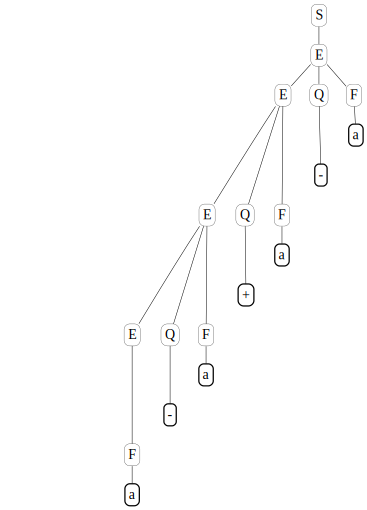

In [43]:
d = Derivation(G)
for P in derivations[0]:
    d = d.rightmost(G.P.index(P))
ProductionGraph(d)